# Loading MODEL 1 data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Unzipping train_data

!unzip -uq "/content/drive/My Drive/Project3/train_data.zip" -d "/content/drive/My Drive/Project3"

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'/content/drive/My Drive/Project3/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('/content/drive/My Drive/Project3/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('/content/drive/My Drive/Project3/noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


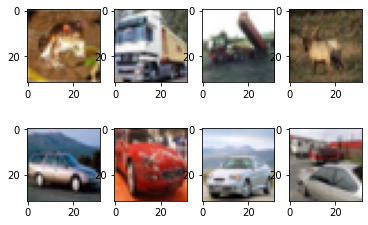

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[49998]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[49999]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

# Loading MODEL 2 cleaned labels:

In [7]:
# load the labels
new_clean_labels = np.genfromtxt('/content/drive/My Drive/Project3_CleanedLabel/cleaned_labels_resnet.txt', delimiter=',', dtype="int8")

# Combining original cleaned labels with new cleaned labels:

In [14]:
new_clean_labels = np.append(clean_labels, new_clean_labels)

# Running model on cleaned labels

In [20]:
X = imgs
y = new_clean_labels

In [22]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [23]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [24]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [25]:
import tensorflow.keras as K
import tensorflow as tf

In [26]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [27]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [28]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [29]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [30]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [31]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

16705208/16705208 [==============================] - 0s 0us/step


In [32]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
# out = K.layers.Dense(256, activation='relu')(out)
# out = K.layers.Dropout(0.3)(out)
# out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [33]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [34]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.2,
                                            patience=2))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [35]:
model = K.models.Model(inputs=inputs, outputs=out)

In [36]:
from tensorflow.keras import layers 

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [37]:
unfreeze_model(model)

In [43]:
# train
model.fit_generator(datagen.flow(x=x_train,
          y=y_train,
          batch_size=128),steps_per_epoch = len(x_train) / 128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


312/312 [==============================] - 198s 632ms/step - loss: 2.3558 - accuracy: 0.1454 - val_loss: 2.2433 - val_accuracy: 0.2038 - lr: 1.0000e-04
Epoch 2/20
312/312 [==============================] - 203s 649ms/step - loss: 2.3225 - accuracy: 0.1587 - val_loss: 2.2344 - val_accuracy: 0.2112 - lr: 1.0000e-04
Epoch 3/20
312/312 [==============================] - 204s 653ms/step - loss: 2.2953 - accuracy: 0.1681 - val_loss: 2.2261 - val_accuracy: 0.2250 - lr: 1.0000e-04
Epoch 4/20
312/312 [==============================] - 202s 646ms/step - loss: 2.2777 - accuracy: 0.1811 - val_loss: 2.2219 - val_accuracy: 0.2282 - lr: 1.0000e-04
Epoch 5/20
312/312 [==============================] - 205s 654ms/step - loss: 2.2644 - accuracy: 0.1931 - val_loss: 2.2177 - val_accuracy: 0.2370 - lr: 1.0000e-04
Epoch 6/20
312/312 [==============================] - 199s 638ms/step - loss: 2.2544 - accuracy: 0.2010 - val_loss: 2.2153 - val_accuracy: 0.2358 - lr: 1.0000e-04
Epoch 7/20
312/312 [=============

In [44]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [45]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 15ms/step


In [46]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [47]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 45ms/step - loss: 2.2186 - accuracy: 0.2374


[2.218580722808838, 0.23739999532699585]

# TRAINING THE BEST MODEL ON ALL 50K SAMPLE:

# RUN BELOW CODE TO GIVE OUTPUT FOR FINAL TEST SET